In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import seaborn as sns

import os

import torch
import torchvision.datasets as dset
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
from pyro.contrib.examples.util import print_and_log
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam

# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

USE_CUDA = True

pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

In [2]:
class Encoder(nn.Module):
    def __init__(self, image_dim, label_dim, z_dim):
        super(Encoder, self).__init__()
        self.image_dim = image_dim
        self.label_dim = label_dim
        self.z_dim = z_dim
        # setup the three linear transformations used
        self.fc1 = nn.Linear(self.image_dim+self.label_dim, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc31 = nn.Linear(1000, z_dim)  # mu values
        self.fc32 = nn.Linear(1000, z_dim)  # sigma values
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, xs, ys):
        # define the forward computation on the image xs and label ys
        # first shape the mini-batch to have pixels in the rightmost dimension
        xs = xs.reshape(-1, self.image_dim)
        #now concatenate the image and label
        inputs = torch.cat((xs,ys), -1)
        # then compute the hidden units
        hidden1 = self.softplus(self.fc1(inputs))
        hidden2 = self.softplus(self.fc2(hidden1))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc31(hidden2)
        z_scale = torch.exp(self.fc32(hidden2))
        return z_loc, z_scale
    
class Decoder(nn.Module):
    def __init__(self, image_dim, label_dim, z_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        hidden_dim = 1000
        self.fc1 = nn.Linear(z_dim+label_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, image_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, zs, ys):
        # define the forward computation on the latent z and label y
        # first concatenate z and y
        inputs = torch.cat((zs, ys),-1)
        # then compute the hidden units
        hidden1 = self.softplus(self.fc1(inputs))
        hidden2 = self.softplus(self.fc2(hidden1))
        hidden3 = self.softplus(self.fc3(hidden2))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc4(hidden3))
        return loc_img

In [3]:
class CVAE(nn.Module):

    def __init__(self, config_enum=None, use_cuda=False, aux_loss_multiplier=None):

        super(CVAE, self).__init__()
    
        self.image_dim = 64**2
        self.label_shape = np.array((1,3,6,40,32,32))
        self.label_names = np.array(('color', 'shape', 'scale', 'orientation', 'posX', 'posY'))
        self.label_dim = np.sum(self.label_shape)
        self.z_dim = 50                                           
        self.allow_broadcast = config_enum == 'parallel'
        self.use_cuda = use_cuda
        self.aux_loss_multiplier = aux_loss_multiplier

        # define and instantiate the neural networks representing
        # the paramters of various distributions in the model
        self.setup_networks()

    def setup_networks(self):
        self.encoder = Encoder(self.image_dim, self.label_dim, self.z_dim)

        self.decoder = Decoder(self.image_dim, self.label_dim, self.z_dim)

        # using GPUs for faster training of the networks
        if self.use_cuda:
            self.cuda()

    def model(self, xs, ys):
        """
        The model corresponds to the following generative process:
        p(z) = normal(0,I)              # dsprites label (latent)
        p(y|x) = categorical(I/10.)     # which digit (supervised)
        p(x|y,z) = bernoulli(loc(y,z))   # an image
        loc is given by a neural network  `decoder`

        :param xs: a batch of scaled vectors of pixels from an image
        :param ys: a batch of the class labels i.e.
                   the digit corresponding to the image(s)
        :return: None
        """
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("cvae", self)

        batch_size = xs.size(0)
        options = dict(dtype=xs.dtype, device=xs.device)
        with pyro.plate("data"):

            prior_loc = torch.zeros(batch_size, self.z_dim, **options)
            prior_scale = torch.ones(batch_size, self.z_dim, **options)
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))
            
            # if the label y (which digit to write) is supervised, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)
    
            loc = self.decoder.forward(zs, self.remap_y(ys))
            pyro.sample("x", dist.Bernoulli(loc).to_event(1), obs=xs)
            # return the loc so we can visualize it later
            return loc

    def guide(self, xs, ys):
        """
        The guide corresponds to the following:
        q(z|x,y) = normal(loc(x,y),scale(x,y))       # infer latent class from an image and the label 
        loc, scale are given by a neural network `encoder`

        :param xs: a batch of scaled vectors of pixels from an image
        :return: None
        """
        # inform Pyro that the variables in the batch of xs are conditionally independent
        with pyro.plate("data"):
            # sample (and score) the latent handwriting-style with the variational
            # distribution q(z|x) = normal(loc(x),scale(x))
    
            loc, scale = self.encoder.forward(xs, self.remap_y(ys))
            pyro.sample("z", dist.Normal(loc, scale).to_event(1))
            
    def remap_y(self, ys):
        new_ys = []
        options = dict(dtype=ys.dtype, device=ys.device)
        for i, label_length in enumerate(self.label_shape):
            prior = torch.ones(ys.size(0), label_length, **options) / (1.0 * label_length)
            new_ys.append(pyro.sample("y_%s" % self.label_names[i], dist.OneHotCategorical(prior), 
                                   obs=torch.nn.functional.one_hot(ys[:,i].to(torch.int64), int(label_length))))
        new_ys = torch.cat(new_ys, -1)
        return new_ys.to(torch.float32)
            
    def reconstruct_image(self, xs, ys):
        # backward
        sim_z_loc, sim_z_scale = self.encoder.forward(xs, self.remap_y(ys))
        zs = dist.Normal(sim_z_loc, sim_z_scale).to_event(1).sample()
        # forward
        loc = self.decoder.forward(zs, self.remap_y(ys))
        return dist.Bernoulli(loc).to_event(1).sample()


In [4]:
def setup_data_loaders(train_x, test_x, train_y, test_y, batch_size=128, use_cuda=False):
    train_dset = torch.utils.data.TensorDataset(
        torch.from_numpy(train_x.astype(np.float32)).reshape(-1, 4096),
        torch.from_numpy(train_y.astype(np.float32))
    )
    
    test_dset = torch.utils.data.TensorDataset(
        torch.from_numpy(test_x.astype(np.float32)).reshape(-1, 4096),
        torch.from_numpy(test_y.astype(np.float32))
    )    
    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dset, batch_size=batch_size, shuffle=False, **kwargs
    )
    
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dset, batch_size=batch_size, shuffle=False, **kwargs
    )
    
    return {"train":train_loader, "test":test_loader}

In [5]:
dataset_zip = np.load(
    'dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz',
    encoding = 'bytes',
    allow_pickle=True
)
imgs = dataset_zip['imgs']
labels = dataset_zip['latents_classes']
label_sizes = dataset_zip['metadata'][()][b'latents_sizes']
label_names = dataset_zip['metadata'][()][b'latents_names']

# Sample imgs randomly
indices_sampled = np.arange(imgs.shape[0])
np.random.shuffle(indices_sampled)
imgs_sampled = imgs[indices_sampled]
labels_sampled = labels[indices_sampled]

data_loaders = setup_data_loaders(
    imgs_sampled[1000:],
    imgs_sampled[:1000],
    labels_sampled[1000:],
    labels_sampled[:1000],
    batch_size=256,
    use_cuda=USE_CUDA
)


In [6]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for xs,ys in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            xs = xs.cuda()
            ys = ys.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(xs, ys)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for xs, ys in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            xs = xs.cuda()
            ys = ys.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(xs, ys)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [7]:
# Run options
LEARNING_RATE = 1.0e-3

# Run only for a single iteration for testing
NUM_EPOCHS = 0
TEST_FREQUENCY = 5

In [8]:
#################################
### FOR SAVING AND LOADING MODEL
################################
# clear param store
pyro.clear_param_store()

PATH = "trained_model.save"

# new model
# vae = CVAE(use_cuda=USE_CUDA)

# save current model
# torch.save(vae.state_dict(), PATH)

# to load params from trained model
vae = CVAE(use_cuda=USE_CUDA)
vae.load_state_dict(torch.load(PATH))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [9]:
import warnings
warnings.filterwarnings('ignore')

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop

VERBOSE = True
pbar = tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    total_epoch_loss_train = train(svi, data_loaders["train"], use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    if VERBOSE:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, data_loaders["test"], use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        if VERBOSE:
            print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

#### Visualizing the reconstruction accuracy

In [10]:
data_iter = iter(data_loaders["train"])
xs, ys = next(data_iter)
if USE_CUDA:
    xs = xs.cuda()
    ys = ys.cuda()
rs = vae.reconstruct_image(xs, ys)
if USE_CUDA:
    xs = xs.cpu()
    rs = rs.cpu()
originals = xs.numpy().reshape(-1, 64,64)
recons = rs.numpy().reshape(-1,64,64)

In [11]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(x):
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    plt.imshow(originals[x], cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    ax1 = fig.add_subplot(122)
    plt.imshow(recons[x], cmap='Greys_r',  interpolation='nearest')
    plt.axis('off')
    
interact(f, x=widgets.IntSlider(min=0, max=xs.shape[0], step=1, value=0));

interactive(children=(IntSlider(value=0, description='x', max=256), Output()), _dom_classes=('widget-interact'…

In [265]:
def vis(x):
    if x.is_cuda:
        x = x.cpu()
    plt.figure()
    plt.imshow(x.reshape(64,64), interpolation='nearest', cmap='Greys_r')
    plt.axis('off')

### Create SCM

In [266]:
def SCM(vae, mu, sigma):
    z_dim = vae.z_dim
    Nx = pyro.sample("Nx", dist.Uniform(torch.zeros(vae.image_dim), torch.ones(vae.image_dim)))
    Nz = pyro.sample("Nz", dist.Normal(torch.zeros(z_dim), torch.ones(z_dim)))
    Ny = []
    Y = []
    ys = []
    m = torch.distributions.gumbel.Gumbel(torch.tensor(0.0), torch.tensor(1.0))
    for label_id in range(6):
        name = vae.label_names[label_id]
        length = vae.label_shape[label_id]
        new = pyro.sample("Ny_%s"%name, dist.Uniform(torch.zeros(length), torch.ones(length)) )
        Ny.append(new)
        gumbel_vars = torch.tensor([m.sample() for _ in range(length)])
        max_ind = torch.argmax(torch.log(new) + gumbel_vars).item()
        Y.append(pyro.sample("Y_%s"%name, dist.Normal(torch.tensor(max_ind*1.0), 1e-4)))
        ys.append(torch.nn.functional.one_hot(torch.tensor(max_ind), int(length)))
                 
    Y = torch.tensor(Y)
    ys = torch.cat(ys).to(torch.float32).reshape(1,-1).cuda()
    Z = pyro.sample("Z", dist.Normal(mu + Nz*sigma, 1e-4))
    zs = Z.cuda()
    p = vae.decoder.forward(zs,ys).cpu()
    X = pyro.sample("X", dist.Normal((Nx < p).to(torch.float), 1e-4))
    return X, Y, Z
    

In [267]:
xs, ys = next(data_iter)
x = xs[0].reshape(1,-1).cuda()
y = ys[0].reshape(1,-1).cuda()

mu, sigma = vae.encoder.forward(x,vae.remap_y(y))
mu = mu.cpu()
sigma = sigma.cpu()

x_, y_, z_ = SCM(vae, mu, sigma)

In [272]:
from pyro.infer.importance import Importance
from pyro.infer.mcmc import MCMC
from pyro.infer.mcmc.nuts import HMC

intervened_model = pyro.do(SCM, data={"Y_shape": torch.tensor(0.)})
conditioned_model = pyro.condition(SCM, data={"Y_shape": torch.tensor(1.0)})

posterior = pyro.infer.Importance(conditioned_model, num_samples = 10000)
posterior.run(vae, mu, sigma)



(-0.5, 63.5, 63.5, -0.5)

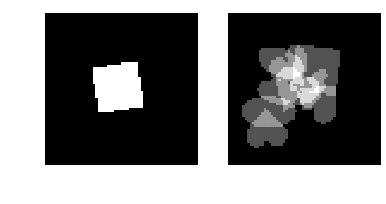

In [275]:
N = 10
result = np.zeros((N, vae.image_dim))
for i in range(N):
    trace = posterior()
    data = dict()
    noise_vars = ['Ny_' + s for s in vae.label_names] + ['Nx', 'Nz']
    for name in noise_vars:
        data[name] = trace.nodes[name]['value']
        
    con_obj = pyro.condition(intervened_model, data = data)
    result[i] = con_obj(vae, mu, sigma)[0]
    
# now generate density image
dens_img = np.mean(result, axis=0).reshape(64,64)
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(x.cpu().reshape(64,64), interpolation='nearest', cmap="Greys_r")
plt.axis('off')

fig.add_subplot(122)
plt.imshow(dens_img, interpolation='nearest', cmap="Greys_r")
plt.axis('off')
